# 요긴가 조
## 인공신경망을 이용한 음식점 추천
### 목표: 뉴럴 네트워크 모델을 설계한 후 학습하여 각 음식점의 embedding들을 생성하고, 음식점 embedding을 활용하여 각 사용자에게 맞춤형 영화를 추천

In [2]:
import warnings, random
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import mplcursors
import numpy as np
import torch
import torch.optim as optim
from torch import nn
import torch.nn.functional as F
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from scipy.spatial.distance import cdist
from itertools import permutations # For making pairs

import matplotlib.font_manager as fm
from matplotlib import rc

fm.get_fontconfig_fonts()
# 디렉토리 및 파일 이름에 맞추어 변경
#font_location = '/Users/sungsu/Library/Fonts/D2Coding-Ver1.3.2-20180524.ttf'
#font_name = fm.FontProperties(fname=font_location).get_name()
rc('font', family='Malgun Gothic')
#print(font_name)
warnings.filterwarnings('ignore')

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 1.11.0  Device: cpu


### 크롤링한 데이터 전처리

In [4]:
# 음식점의 카테고리를 가진 Dataframe
df_category = pd.read_csv('./restaurant_category.csv',index_col=0)
df_category

,분식,일식&돈까스,족발&보쌈,중국집,치킨,피자&양식,한식
매운국물떡볶이밀방떡-홍대입구점,1,0,0,0,0,0,0
가이오돈까스&국수,1,1,0,0,0,0,1
홍대마늘떡볶이-홍마떡본점,1,0,0,0,0,0,0
한입타코야끼,1,0,0,0,0,0,0
걸작떡볶이치킨-서울합정점,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...
한남불닭,0,0,0,0,0,0,1
큰맘할매순대국-홍대점,0,0,0,0,0,0,1
"상수,곱도리탕",0,0,0,0,0,0,1
베트남쌀국수퍼사이공-신촌점,0,0,0,0,0,0,1


In [5]:
# 사용자들의 리뷰들을 가진 Dataframe
df = pd.read_csv(
    './YogingaDataSet.csv'
)
df.head(2)

,Unnamed: 0,Restaurant,UserID,Menu,Review,Total,Taste,Quantity,Delivery,Date
0,0,꽃게나라 간장게장,wu**님,（XL）간장게장 대 정식 100%연평도암꽃게/1(메뉴 선택(1미+김치찌개+계란날밥 ...,조카가 먹고 싶다고 해서 시켰는데 잘 먹었습니다. 감사합니다.,5,5.0,5.0,5.0,2022년 4월 21일
1,1,꽃게나라 간장게장,ff**님,NaN,안 짜서 너무 좋았어요 비린맛도 없고 깔끔한 맛이라 다음에 또 시켜먹을 거 같습니다~,5,5.0,5.0,5.0,2022년 4월 16일


In [6]:
# 별점 Total 열을 Rating으로 이름 변경 
df.rename(columns={'Total':'Rating'},inplace = True)
#음식점 이름, UserID, Rating만 남긴다.
df = df.filter(['Restaurant', 'UserID', 'Rating'])

df.head(10)

,Restaurant,UserID,Rating
0,꽃게나라 간장게장,wu**님,5
1,꽃게나라 간장게장,ff**님,5
2,꽃게나라 간장게장,zh**님,5
3,꽃게나라 간장게장,kw**님,5
4,꽃게나라 간장게장,dk**님,5
5,꽃게나라 간장게장,jw**님,5
6,키싸-디저트&눈꽃빙수,ej**님,5
7,키싸-디저트&눈꽃빙수,ej**님,5
8,키싸-디저트&눈꽃빙수,ej**님,5
9,키싸-디저트&눈꽃빙수,fo**님,4


In [7]:
# 유저와 음식점 개수 확인
n_users = len(df['UserID'].unique())
n_restaurants = len(df['Restaurant'].unique())

n_users, n_restaurants

(1309, 635)

In [8]:
df['Rating'].describe()

count    358132.000000
mean          4.739440
std           0.731522
min           0.000000
25%           5.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: Rating, dtype: float64

### Utility Matrix 생성: 중복 리뷰는 평균 aggregation으로 처리

In [9]:
#user-restaurant utility matrix
#UserID = '손님' 제거
user_restaurant = df.pivot_table('Rating',index='UserID',columns = 'Restaurant',aggfunc='mean')
user_restaurant.drop(user_restaurant.loc[['손님'],:].index, inplace = True)
print(user_restaurant.shape)

#restaurant-restaurant utility matrix
restaurant_user = df.pivot_table('Rating',index='Restaurant',columns = 'UserID',aggfunc='mean')
restaurant_user.drop(restaurant_user[['손님']], inplace = True, axis = 1)
print(restaurant_user.shape)


(1307, 634)
(634, 1307)


### 음식점의 평균 평점을 구해 상위평점의 음식점 구하기
1. 음식점 2곳 이상 리뷰를 단 user 를 찾는다.
2. 해당 user들에게 리뷰가 달리지 않은 음식점을 Drop 한다.
3. 그렇게 만들어진 Utility Matrix로 음식점들의 ID를 설정하고 해당 정보를 저장한다.
4. Utility Matrix의 row와 column을 숫자로 변경한다.
4. 음식점들의 순열을 구해 pair에 저장한다.

In [10]:
# 상위 리뷰 처리
#sum(df_utility.count(axis=1).loc[df_utility.mean(axis=1)>=4.85])
#df_utility = restaurant_user.loc[restaurant_user.mean(axis=1)>=4.85]

#### 1. 음식점 2곳 이상 리뷰를 단 user 찾기

In [11]:
user_mask = restaurant_user.columns[restaurant_user.count(axis=0)>1]

#### 2. 해당 user들에게 리뷰가 달리지 않은 음식점을 Drop하기

In [12]:
restaurant_user[user_mask].sum(axis=1).sort_values()

Restaurant
더정원보쌈족발                    0.000000
홍대자연보쌈세트                   0.000000
서두산딤섬만두-홍대점                3.000000
마포구회맛집                     5.000000
NAMJAPIZZA&SPAGHETTI       5.000000
                           ...     
또래오래-마포망원점              2288.101669
롯데리아-망원점                2312.610164
후라이드참잘하는집-마포점           2478.504742
치킨플러스-성산점               2731.477306
대족장                     3293.180453
Length: 634, dtype: float64

In [13]:
df_utility = restaurant_user[user_mask]
df_utility.drop(['더정원보쌈족발','홍대자연보쌈세트'],inplace=True)
df_utility

UserID,-_**님,-b**님,-c**님,-e**님,-g**님,-m**님,00**님,01**님,02**님,03**님,...,zq**님,zr**님,zs**님,zt**님,zu**님,zv**님,zw**님,zx**님,zy**님,zz**님
Restaurant,,,,,,,,,,,,,,,,,,,,,
10평파스타&화덕피자,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1인기사식당,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,NaN,NaN,...,NaN,NaN,5.0,NaN,NaN,NaN,5.0,3.0,NaN,NaN
1인살로만강명수아구찜앤탕-마포본점,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1인용마라탕-서울수색점,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1인용묵은지김치찜-서울수색점,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
회대장산지직송숙성활어전문점,NaN,5.0,NaN,NaN,NaN,NaN,NaN,5.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
회뜨는총각-연남점,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
후라이드참잘하는집-마포점,5.0,NaN,NaN,5.0,NaN,NaN,NaN,4.285714,5.0,5.0,...,NaN,NaN,5.0,NaN,5.0,NaN,NaN,5.0,NaN,4.777778


#### 4. 음식점과 유저 id설정

In [14]:
restaurant_id = list(df_utility.index)
user_id = list(df_utility.columns)

In [15]:
restaurant_dict = {string:i for i,string in enumerate(restaurant_id)}
user_dict = {string:i for i,string in enumerate(user_id)}

In [16]:
restaurant_dict

{'10평파스타&화덕피자': 0,
 '1인기사식당': 1,
 '1인살로만강명수아구찜앤탕-마포본점': 2,
 '1인용마라탕-서울수색점': 3,
 '1인용묵은지김치찜-서울수색점': 4,
 '1인찌개와탕&냉면': 5,
 '1인한솥명가갈비찜-월곡점': 6,
 '1인할매보쌈족발-월곡점': 7,
 '24시 진짜루': 8,
 '5959양꼬치&마라탕': 9,
 '5인삼겹살곱창': 10,
 '60계-망원점': 11,
 '7번가피자-서교망원점': 12,
 '88전복죽': 13,
 'ASAPPIZZA-홍대점': 14,
 'BBQ-망원점': 15,
 'BHC-망원점': 16,
 'BHC-합정역점': 17,
 'JH집밥김치찌개': 18,
 'JohnHouse': 19,
 'KFC-홍익대점': 20,
 'KFC-홍익대점(심야)': 21,
 'NAMJAPIZZA&SPAGHETTI': 22,
 'NAPALPIZZA&WINE': 23,
 'OK피자시즌2': 24,
 'The진한나주곰탕1인용-홍대점': 25,
 'The청춘키친-은평점': 26,
 'USA존슨부대찌개-수색점': 27,
 '가마로강정-광흥창점': 28,
 '가마로강정-망원점': 29,
 '가마로강정-상암점': 30,
 '가마치통닭-서울망원역점': 31,
 '가분뼈다귀해장국&김치찜-강북점': 32,
 '가이오돈까스&국수': 33,
 '가장맛있는족발-상암디지털역점': 34,
 '갈비마마-응암점': 35,
 '감미분식-연남점': 36,
 '감성카츠': 37,
 '갓피맥-상암점': 38,
 '강릉어시장회': 39,
 '강릉초당골짬뽕순두부-마포점': 40,
 '강명수묵은지김치찜-마포본점': 41,
 '건강한이불덮밥&장어규동': 42,
 '걸작떡볶이치킨-서울광흥창점': 43,
 '걸작떡볶이치킨-서울상암점': 44,
 '걸작떡볶이치킨-서울신촌점': 45,
 '걸작떡볶이치킨-서울합정점': 46,
 '고기왕창자이언트비빔밥-홍대점': 47,
 '고돼지-신촌점': 48,
 '고릴라요정': 49,
 '고봉이네1인분생고기김치찌개': 50,
 '고유식탁

In [17]:
user_dict

{'-_**님': 0,
 '-b**님': 1,
 '-c**님': 2,
 '-e**님': 3,
 '-g**님': 4,
 '-m**님': 5,
 '00**님': 6,
 '01**님': 7,
 '02**님': 8,
 '03**님': 9,
 '04**님': 10,
 '05**님': 11,
 '06**님': 12,
 '07**님': 13,
 '08**님': 14,
 '09**님': 15,
 '0_**님': 16,
 '0a**님': 17,
 '0b**님': 18,
 '0d**님': 19,
 '0h**님': 20,
 '0k**님': 21,
 '0l**님': 22,
 '0m**님': 23,
 '0n**님': 24,
 '0o**님': 25,
 '0s**님': 26,
 '0w**님': 27,
 '0y**님': 28,
 '0z**님': 29,
 '10**님': 30,
 '11**님': 31,
 '12**님': 32,
 '13**님': 33,
 '14**님': 34,
 '15**님': 35,
 '16**님': 36,
 '17**님': 37,
 '18**님': 38,
 '19**님': 39,
 '1_**님': 40,
 '1a**님': 41,
 '1b**님': 42,
 '1d**님': 43,
 '1e**님': 44,
 '1g**님': 45,
 '1i**님': 46,
 '1j**님': 47,
 '1m**님': 48,
 '1n**님': 49,
 '1o**님': 50,
 '1q**님': 51,
 '1s**님': 52,
 '1w**님': 53,
 '20**님': 54,
 '21**님': 55,
 '22**님': 56,
 '23**님': 57,
 '24**님': 58,
 '25**님': 59,
 '26**님': 60,
 '27**님': 61,
 '28**님': 62,
 '29**님': 63,
 '2_**님': 64,
 '2b**님': 65,
 '2d**님': 66,
 '2e**님': 67,
 '2g**님': 68,
 '2h**님': 69,
 '2j**님': 70,
 '2k**님': 71,
 '

#### 4. Utility Matrix의 행과 열을 숫자로 변경

In [18]:
df_utility = df_utility.reset_index()

In [19]:
df_utility.index.name = 'RestaurantID'

In [20]:
df_utility = df_utility.rename(columns=user_dict)

In [21]:
df_utility = df_utility.drop(['Restaurant'],axis=1)

In [22]:
df_utility

UserID,0,1,2,3,4,5,6,7,8,9,...,1161,1162,1163,1164,1165,1166,1167,1168,1169,1170
RestaurantID,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,NaN,NaN,...,NaN,NaN,5.0,NaN,NaN,NaN,5.0,3.0,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
627,NaN,5.0,NaN,NaN,NaN,NaN,NaN,5.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
628,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
629,5.0,NaN,NaN,5.0,NaN,NaN,NaN,4.285714,5.0,5.0,...,NaN,NaN,5.0,NaN,5.0,NaN,NaN,5.0,NaN,4.777778


#### 5. 음식점들의 순열을 구해 pair에 저장

In [23]:
df_utility[3].loc[df_utility[3].notna()].index

Int64Index([ 19, 116, 156, 217, 232, 319, 321, 367, 391, 453, 481, 503, 554,
            555, 583, 592, 612, 629],
           dtype='int64', name='RestaurantID')

In [24]:
train_pairs=[]
test_pairs=[]
for i in range(1171):
    row_ate = list(df_utility[i].loc[df_utility[i].notna()].index)
    random.shuffle(row_ate)
    if len(row_ate) >= 12:
        bound = len(row_ate)*9//10
        train_pairs = train_pairs + list(permutations(row_ate[:bound],2))
        test_pairs = test_pairs + list(permutations(row_ate[bound:],2))
    else:
        train_pairs = train_pairs + list(permutations(row_ate,2))
    if(i%110 == 0):
        print(len(train_pairs),len(test_pairs))

272 2
136268 1712
173568 2162
861508 10818
2151424 26792
3141240 39058
4515794 56088
5615900 69738
6344152 78662
7886002 97596
8339898 103186


In [25]:
# 저장한 pair들을 랜덤하게 섞는다.
random.shuffle(train_pairs)
random.shuffle(test_pairs)
train_pairs = torch.tensor(train_pairs)
test_pairs = torch.tensor(test_pairs)
print(len(train_pairs))
print(len(test_pairs))

8741950
108190


In [26]:
xa = torch.tensor([[1,2,3],[4,5,6]])
xb = torch.tensor([[11,22,33],[44,55,66]])
torch.cat([xa,xb],dim=1)

tensor([[ 1,  2,  3, 11, 22, 33],
        [ 4,  5,  6, 44, 55, 66]])

### 모델 설계 및 학습 시키기
1. 모델 설계하기
2. batch 함수
3. Train epoch 함수
4. Test epoch 함수
5. Training 함수
6. 모델 생성 및 학습

#### 1. 모델 설계
- 임베딩 사이즈는 50
- 입력은 음식점의 one-hot vector
- 음식점의 Category Feature를 받아 Hidden Layer의 입력으로 쓴다.

In [27]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.il = nn.Linear(632,50,bias=False)
        self.ho = nn.Linear(57,632,bias=False)
        self.relu = nn.ReLU()
    
    def forward(self,x,category):
        x = self.il(x)
        x = self.relu(x)
        x = torch.cat([x,category],dim=1)
        x = self.ho(x)
        return x

In [28]:
# Parameter 를 Xavier 방식으로 초기화
def init_weights(m):
    if isinstance(m,nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
def init_weights_he(m):
    if isinstance(m,nn.Linear):
        torch.nn.init.kaiming_normal(m.weight, nonlinearity='relu')

#### 2. batch 크기만큼 data를 잘라서 주는 함수

In [29]:
def batch(iterable,n=1):
    l = len(iterable)
    for ndx in range(0,l,n):
        bat = iterable[ndx:min(ndx+n,l)]
        yield (bat[:,0],bat[:,1])

In [30]:
# 음식점 이름들의 category feature를 반환하는 함수
def get_category(id_list=list()):
    id_list = list(id_list)
    rest_list = []
    for _id in id_list:
        rest_list.append(restaurant_id[_id])
    tensor_cat = torch.tensor(df_category.loc[rest_list].values)
    return tensor_cat.float()
for rest,label in batch(train_pairs,10):
    print(get_category(rest))
    break

tensor([[0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0., 0.],
        [1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0., 0.]])


#### 3. Train epoch 함수

In [31]:
def training_epoch(train_loader, network, loss_func, optimizer, epoch):
    train_losses = []
    train_correct = 0
    log_interval = 1700
    Batch = 2048
    for batch_idx, (rest, label) in enumerate(batch(train_loader,Batch)):
        # 미분값의 초기화
        optimizer.zero_grad()
        batch_size = len(rest)
        one_rest = F.one_hot(rest,num_classes=632).float()
        catg = get_category(rest)
        
        # Forward propagration 계산하기
        if device.type == 'cuda':
            rest = rest.to('cuda')
            one_rest = one_rest.to('cuda')
            catg = catg.to('cuda')
            label = label.to('cuda')
        outputs = network.forward(one_rest,catg)
        
        
        # Cross_entropy 함수를 적용하여 loss를 구하고 저장하기
        loss = loss_func(outputs,label)
        train_losses.append(loss.item())

        # training accuracy 정확도 구하기 위해 맞는 샘플 개수 세기
        pred = torch.argmax(outputs,dim=1)
        train_correct += pred.eq(label).sum()
        #print(f"{pred[0]}, {label[0]}, {pred.eq(label)[0]}")
        # Gradient 구하기
        loss.backward()
        # weight값 update 하기
        optimizer.step()
        # 학습 상황 출력
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'
                  .format(epoch, batch_idx * len(label), len(train_loader),
                          100. * (batch_idx*Batch-(Batch-batch_size)) / len(train_loader),
                          loss.item()))
            
    return train_losses, train_correct

#### 4. Test epoch 함수

In [32]:
def test_epoch(test_loader, network, loss_func):
    correct = 0
    Batch = 2048
    test_losses = []
    
    with torch.no_grad():
        for batch_idx, (rest, label) in enumerate(batch(test_loader,Batch)):
            batch_size = len(rest)
            one_rest = F.one_hot(rest, num_classes=632).float()
            catg = get_category(rest)

            # Forward propagration 계산하기.
            if device.type == 'cuda':
                rest = rest.to('cuda')
                one_rest = one_rest.to('cuda')
                catg = catg.to('cuda')
                label = label.to('cuda')
            outputs = network.forward(one_rest,catg)#채우시오

            # Cross_entropy 함수를 적용하여 loss를 구하기
            loss = loss_func(outputs,label)#채우시오
            test_losses.append(loss.item())

            # Batch 별로 정확도 구하기
            pred = torch.argmax(outputs,dim=1)#채우시오
            correct += pred.eq(label).sum()

        # 전체 정확도 구하기
        test_accuracy = 100. * correct / len(test_loader)

        #중간결과 출력
        print('Test set: Accuracy: {}/{} ({:.0f}%)\n'
              .format(correct, len(test_loader),100. * correct / len(test_loader)))
    return test_losses, test_accuracy


#### 5. Training 함수

In [33]:
def training(network):
    
    learning_rate = 0.007
    epoches = 20
    
    cls_loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(network.parameters(),lr=learning_rate)
    
    train_losses_per_epoch = []
    test_losses_per_epoch = []
    
    train_accuracies = []
    test_accuracies = []
    
    
    for epoch in range(epoches):
                
        # 모델를 학습 중이라고 선언하기
        network.train()
        
        train_losses, train_correct = training_epoch(train_pairs,network,cls_loss,optimizer,epoch)#채우시오
        
        # epoch 별로 loss 평균값, 정확도 구하기
        average_loss = np.mean(train_losses)
        train_losses_per_epoch.append(average_loss)
        
        train_accuracy = train_correct / len(train_pairs) * 100
        train_accuracies.append(train_accuracy)
        
        # epoch 별로 정확도 출력
        print('\nTraining set: Accuracy: {}/{} ({:.0f}%)'
              .format(train_correct, len(train_pairs),100. * train_correct / len(train_pairs)))
        
        # 모델 test 중인 것을 선언하기
        network.eval()
        correct = 0
        with torch.no_grad():
            test_losses, test_accuracy = test_epoch(test_pairs,network,cls_loss)#채우시오

        test_losses_per_epoch.append(np.mean(test_losses))
        test_accuracies.append(test_accuracy)
    
    return train_losses_per_epoch, test_losses_per_epoch, train_accuracies, test_accuracies

#### 6. 모델 생성 및 학습

In [34]:
network = Model()
#network.apply(init_weights)
network.apply(init_weights_he)

if device.type == 'cuda':
    network = network.to('cuda')

In [ ]:
training(network)

Train Epoch: 0 [0/8741950 (0%)]	Loss: 6.478776
Train Epoch: 0 [3481600/8741950 (40%)]	Loss: 6.034380
Train Epoch: 0 [6963200/8741950 (80%)]	Loss: 6.013603

Training set: Accuracy: 46092/8741950 (1%)
Test set: Accuracy: 523/108190 (0%)

Train Epoch: 1 [0/8741950 (0%)]	Loss: 6.051176
Train Epoch: 1 [3481600/8741950 (40%)]	Loss: 6.033159


### (선택) weights 저장

In [35]:
torch.save(network.state_dict(), './weights_57_0.003_80.sd')

In [36]:
import pickle
with open('./weights.p', 'wb') as f:
    pickle.dump(network, f)

### (선택)학습된 모델 파일 불러오기

In [37]:
network = Model()
network.load_state_dict(torch.load('./weights_57_0.003_80.sd',map_location=device))

<All keys matched successfully>

In [38]:
network.eval()

Model(
  (il): Linear(in_features=632, out_features=50, bias=False)
  (ho): Linear(in_features=57, out_features=632, bias=False)
  (relu): ReLU()
)

### 학습한 모델에서 임베딩 가져오기

In [39]:
network.to('cpu')

Model(
  (il): Linear(in_features=632, out_features=50, bias=False)
  (ho): Linear(in_features=57, out_features=632, bias=False)
  (relu): ReLU()
)

In [40]:
with torch.no_grad():
    for p in network.il.parameters():
        embed = torch.tensor(p)
embed = embed.T.numpy()
print(embed.shape)
print(embed)

(632, 50)
[[-0.02424983 -0.0326309   0.03911537 ...  0.01844684  0.1050242
   0.03280305]
 [-0.01481977  0.03820211  0.08022172 ...  0.1777621  -0.00700878
   0.03071455]
 [-0.00515445  0.03712594 -0.0031133  ...  0.02163251  0.08162646
   0.02068569]
 ...
 [-0.05451743 -0.06278197 -0.00497135 ... -0.06525034 -0.05564913
   0.12149328]
 [ 0.0032691   0.09705523  0.03599679 ...  0.03393273  0.032203
  -0.04394952]
 [ 0.05087168 -0.03988972  0.02190331 ... -0.04883964  0.00932838
  -0.0489355 ]]


In [41]:
df_utility

UserID,0,1,2,3,4,5,6,7,8,9,...,1161,1162,1163,1164,1165,1166,1167,1168,1169,1170
RestaurantID,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,NaN,NaN,...,NaN,NaN,5.0,NaN,NaN,NaN,5.0,3.0,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
627,NaN,5.0,NaN,NaN,NaN,NaN,NaN,5.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
628,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
629,5.0,NaN,NaN,5.0,NaN,NaN,NaN,4.285714,5.0,5.0,...,NaN,NaN,5.0,NaN,5.0,NaN,NaN,5.0,NaN,4.777778


## 유저의 임베딩 구하기

### 1. 유저가 먹었던 음식점들의 임베딩을 저장하는 방식

In [42]:
users_ate = []
for i in range(0,1171):
    userl = embed[df_utility.notnull()[i].tolist()]
    users_ate.append(userl)
print(len(users_ate),len(users_ate[0][0]))
integrated_ate = np.array(users_ate)

1171 50


### 2. 유저가 먹었던 음식점 임베딩들의 평균을 저장하는 방식

In [43]:
users_embed = []
for i in range(0,1171):
    useri = embed[df_utility.notnull()[i].tolist()].mean(axis=0)
    if len(useri)==0:
        users_embed.append(torch.tensor([]))
    else:
        users_embed.append(useri)
print(f"({len(users_embed)},{len(users_embed[0])})")
print(users_embed)

(1171,50)
[array([ 0.01925096, -0.00899149,  0.01232674,  0.00337755,  0.0038475 ,
        0.01063136, -0.00384151,  0.01403607, -0.01795527,  0.00599019,
        0.01170448, -0.00938886,  0.00027664, -0.02512137,  0.00959088,
       -0.00813046,  0.00898299,  0.00344121,  0.00694266, -0.00437628,
        0.02144167, -0.00267778,  0.00514247,  0.01525143,  0.01280226,
        0.00360331, -0.00055599,  0.00761239, -0.01464916, -0.01750199,
        0.00858903, -0.0250867 ,  0.00311997,  0.00627108, -0.00932813,
       -0.00026128, -0.00951012,  0.00345505,  0.01548111,  0.00862953,
       -0.00760529,  0.0066082 ,  0.00978914,  0.00867867,  0.00640518,
        0.02075396, -0.00230141, -0.00488247,  0.00796029,  0.03334376],
      dtype=float32), array([-0.02723171, -0.02402988, -0.02507196, -0.00256484, -0.03346693,
       -0.01031972, -0.00200939, -0.01890979, -0.00663085,  0.00811224,
       -0.03660866,  0.03559252,  0.02018918, -0.02267045,  0.02180797,
        0.01450627,  0.0145305

In [44]:
integrated_embed = np.array(users_embed)
print(integrated_embed.shape)
print(embed.shape)

(1171, 50)
(632, 50)


In [45]:
# 음식점들의 평균 rating 구하기
df_restaurant=pd.DataFrame(restaurant_user.mean(axis=1))
df_restaurant.columns = ['Mean_Rating']
df_restaurant

,Mean_Rating
Restaurant,
10평파스타&화덕피자,4.805679
1인기사식당,4.380657
1인살로만강명수아구찜앤탕-마포본점,4.857143
1인용마라탕-서울수색점,4.320000
1인용묵은지김치찜-서울수색점,4.701550
...,...
회대장산지직송숙성활어전문점,4.344086
회뜨는총각-연남점,4.763406
후라이드참잘하는집-마포점,4.797125


### User의 id를 보내면 n개의 음식점을 추천해주는 함수

In [46]:
## user = 0~1171
classes = 632
def recommend_n(user,n):
    user = user
    similarities=np.zeros(classes)
    length = len(users_ate[user])
    for u_emb in users_ate[user]:
        similarities = similarities + (1-cdist(u_emb.reshape(1,-1), embed, metric='cosine'))
    similarities = similarities/length
    #print(similarities.shape)
    #print(similarities)
    #similarities.sort(descending=True)
    sorted_arg = np.argsort(similarities[0])[::-1]
    sorted_arg = sorted_arg[:n]
    recommendations = []
    recom_sim = []
    for i in sorted_arg:
        recommendations.append(restaurant_id[i])
        recom_sim.append(similarities[0][i])
    return recommendations, recom_sim
def restaurantInfo_n(rests,sims):
    tmp = df_restaurant.loc[rests]
    tmp['similarity'] = sims
    return tmp

In [47]:
## user = 0~1171
def recommend(user,n):
    user = user
    similarities = 1 - cdist(integrated_embed[user].reshape((1,-1)), embed, metric='cosine')
    #print(similarities.shape)
    #print(similarities)
    #similarities.sort(descending=True)
    sorted_arg = np.argsort(similarities[0])[::-1]
    sorted_arg = sorted_arg[:n]
    recommendations = []
    recom_sim = []
    for i in sorted_arg:
        recommendations.append(restaurant_id[i])
        recom_sim.append(similarities[0][i])
    return recommendations, recom_sim
def restaurantInfo(rests,sims):
    tmp = df_restaurant.loc[rests]
    tmp['similarity'] = sims
    return tmp

### 방식 1

In [48]:
## user = [1,1170]
search_user = 0
print(user_id[search_user])
recom_restaurantId,recom_similarity = recommend_n(search_user,10)
restaurantInfo_n(recom_restaurantId,recom_similarity)

-_**님


,Mean_Rating,similarity
Restaurant,,
홍리마라탕,4.479266,0.094953
하이디라오-홍대지점,5.000000,0.079436
행복왕갈비,4.844651,0.079198
고유식탁수제함박,4.881857,0.078462
맥소이(MAGSOY),4.812500,0.077406
용무있습니까-상암점,4.785556,0.077081
7번가피자-서교망원점,4.887262,0.076963
치킹맨,4.000000,0.075213
신화루,4.569453,0.072555


### 방식 2

In [49]:
## user = [1,1170]
search_user = 0
print(user_id[search_user])
recom_restaurantId,recom_similarity = recommend(search_user,10)
restaurantInfo(recom_restaurantId,recom_similarity)

-_**님


,Mean_Rating,similarity
Restaurant,,
홍리마라탕,4.479266,0.414651
용무있습니까-상암점,4.785556,0.397600
하이디라오-홍대지점,5.000000,0.388072
7번가피자-서교망원점,4.887262,0.381224
맥소이(MAGSOY),4.812500,0.372781
정성이가득찬집밥-이대점,4.722442,0.371102
행복왕갈비,4.844651,0.359162
고유식탁수제함박,4.881857,0.356249
노량진수산시장삼천포수산,4.800000,0.335014


## TSNE

In [43]:
#결측치 0으로 대체
restaurant_user.fillna(0,inplace = True)
user_restaurant.fillna(0,inplace = True)
df_um = df_utility.fillna(0)

In [44]:
plt.style.use('ggplot')
%matplotlib notebook

In [45]:
# your code here

model_tsne = TSNE(n_components=2)# ,init='random')
W_embedded = model_tsne.fit(embed)# W는 영화에 대한 임베딩이다.

# 실제 2차원으로 변환되었는지 확인
# 변환된 결과는 (n_movies, 2)의 형태
print(W_embedded.embedding_.shape)

(632, 2)


In [46]:
df_um.rename(index={ID:restaurant for ID,restaurant in enumerate(restaurant_id)},inplace=True)

In [47]:
df_um.mean(axis=1)

RestaurantID
10평파스타&화덕피자           0.623794
1인기사식당                0.811787
1인살로만강명수아구찜앤탕-마포본점    0.029035
1인용마라탕-서울수색점          0.092229
1인용묵은지김치찜-서울수색점       0.172644
                        ...   
회대장산지직송숙성활어전문점        0.230003
회뜨는총각-연남점             0.797089
후라이드참잘하는집-마포점         2.116571
희야네반찬                 0.171648
힐링스시-본점               0.087105
Length: 632, dtype: float64

In [48]:
# your code here

# 앞서 정의헀던 Utility Matrix와 동일한 방법으로 A2를 정의 (numpy array로 변환할 필요 없음)
A2 = df_um

# allList엔 A2의 index 값(즉, movieId)들을 list로 변환한 내용이 들어있음
allList = A2.index.values.tolist()

# movie_with_embedding은 df_movies에서 allList와 일치하는 부분만을 가지게 됨
# movie_with_embedding에 'tsne1', 'tsne2' column을 추가 (추가하는 내용은 각각 임베딩의 첫번째 column, 두번째 column)
movie_with_embedding = pd.DataFrame(df_um.mean(axis=1))
movie_with_embedding.columns = ['MeanRating']
movie_with_embedding['tsne1'] = W_embedded.embedding_[:,0]
movie_with_embedding['tsne2'] = W_embedded.embedding_[:,1]

In [49]:
movie_with_embedding

,MeanRating,tsne1,tsne2
RestaurantID,,,
10평파스타&화덕피자,0.623794,-30.071281,15.247096
1인기사식당,0.811787,-30.846445,15.657294
1인살로만강명수아구찜앤탕-마포본점,0.029035,21.806261,2.512585
1인용마라탕-서울수색점,0.092229,8.723186,-4.116107
1인용묵은지김치찜-서울수색점,0.172644,-6.700578,14.979791
...,...,...,...
회대장산지직송숙성활어전문점,0.230003,-2.466878,1.646295
회뜨는총각-연남점,0.797089,10.541495,-0.166574
후라이드참잘하는집-마포점,2.116571,12.522133,-10.793693


In [50]:
movie_with_embedding.loc['힐링스시-본점'].name

'힐링스시-본점'

<IPython.core.display.Javascript object>


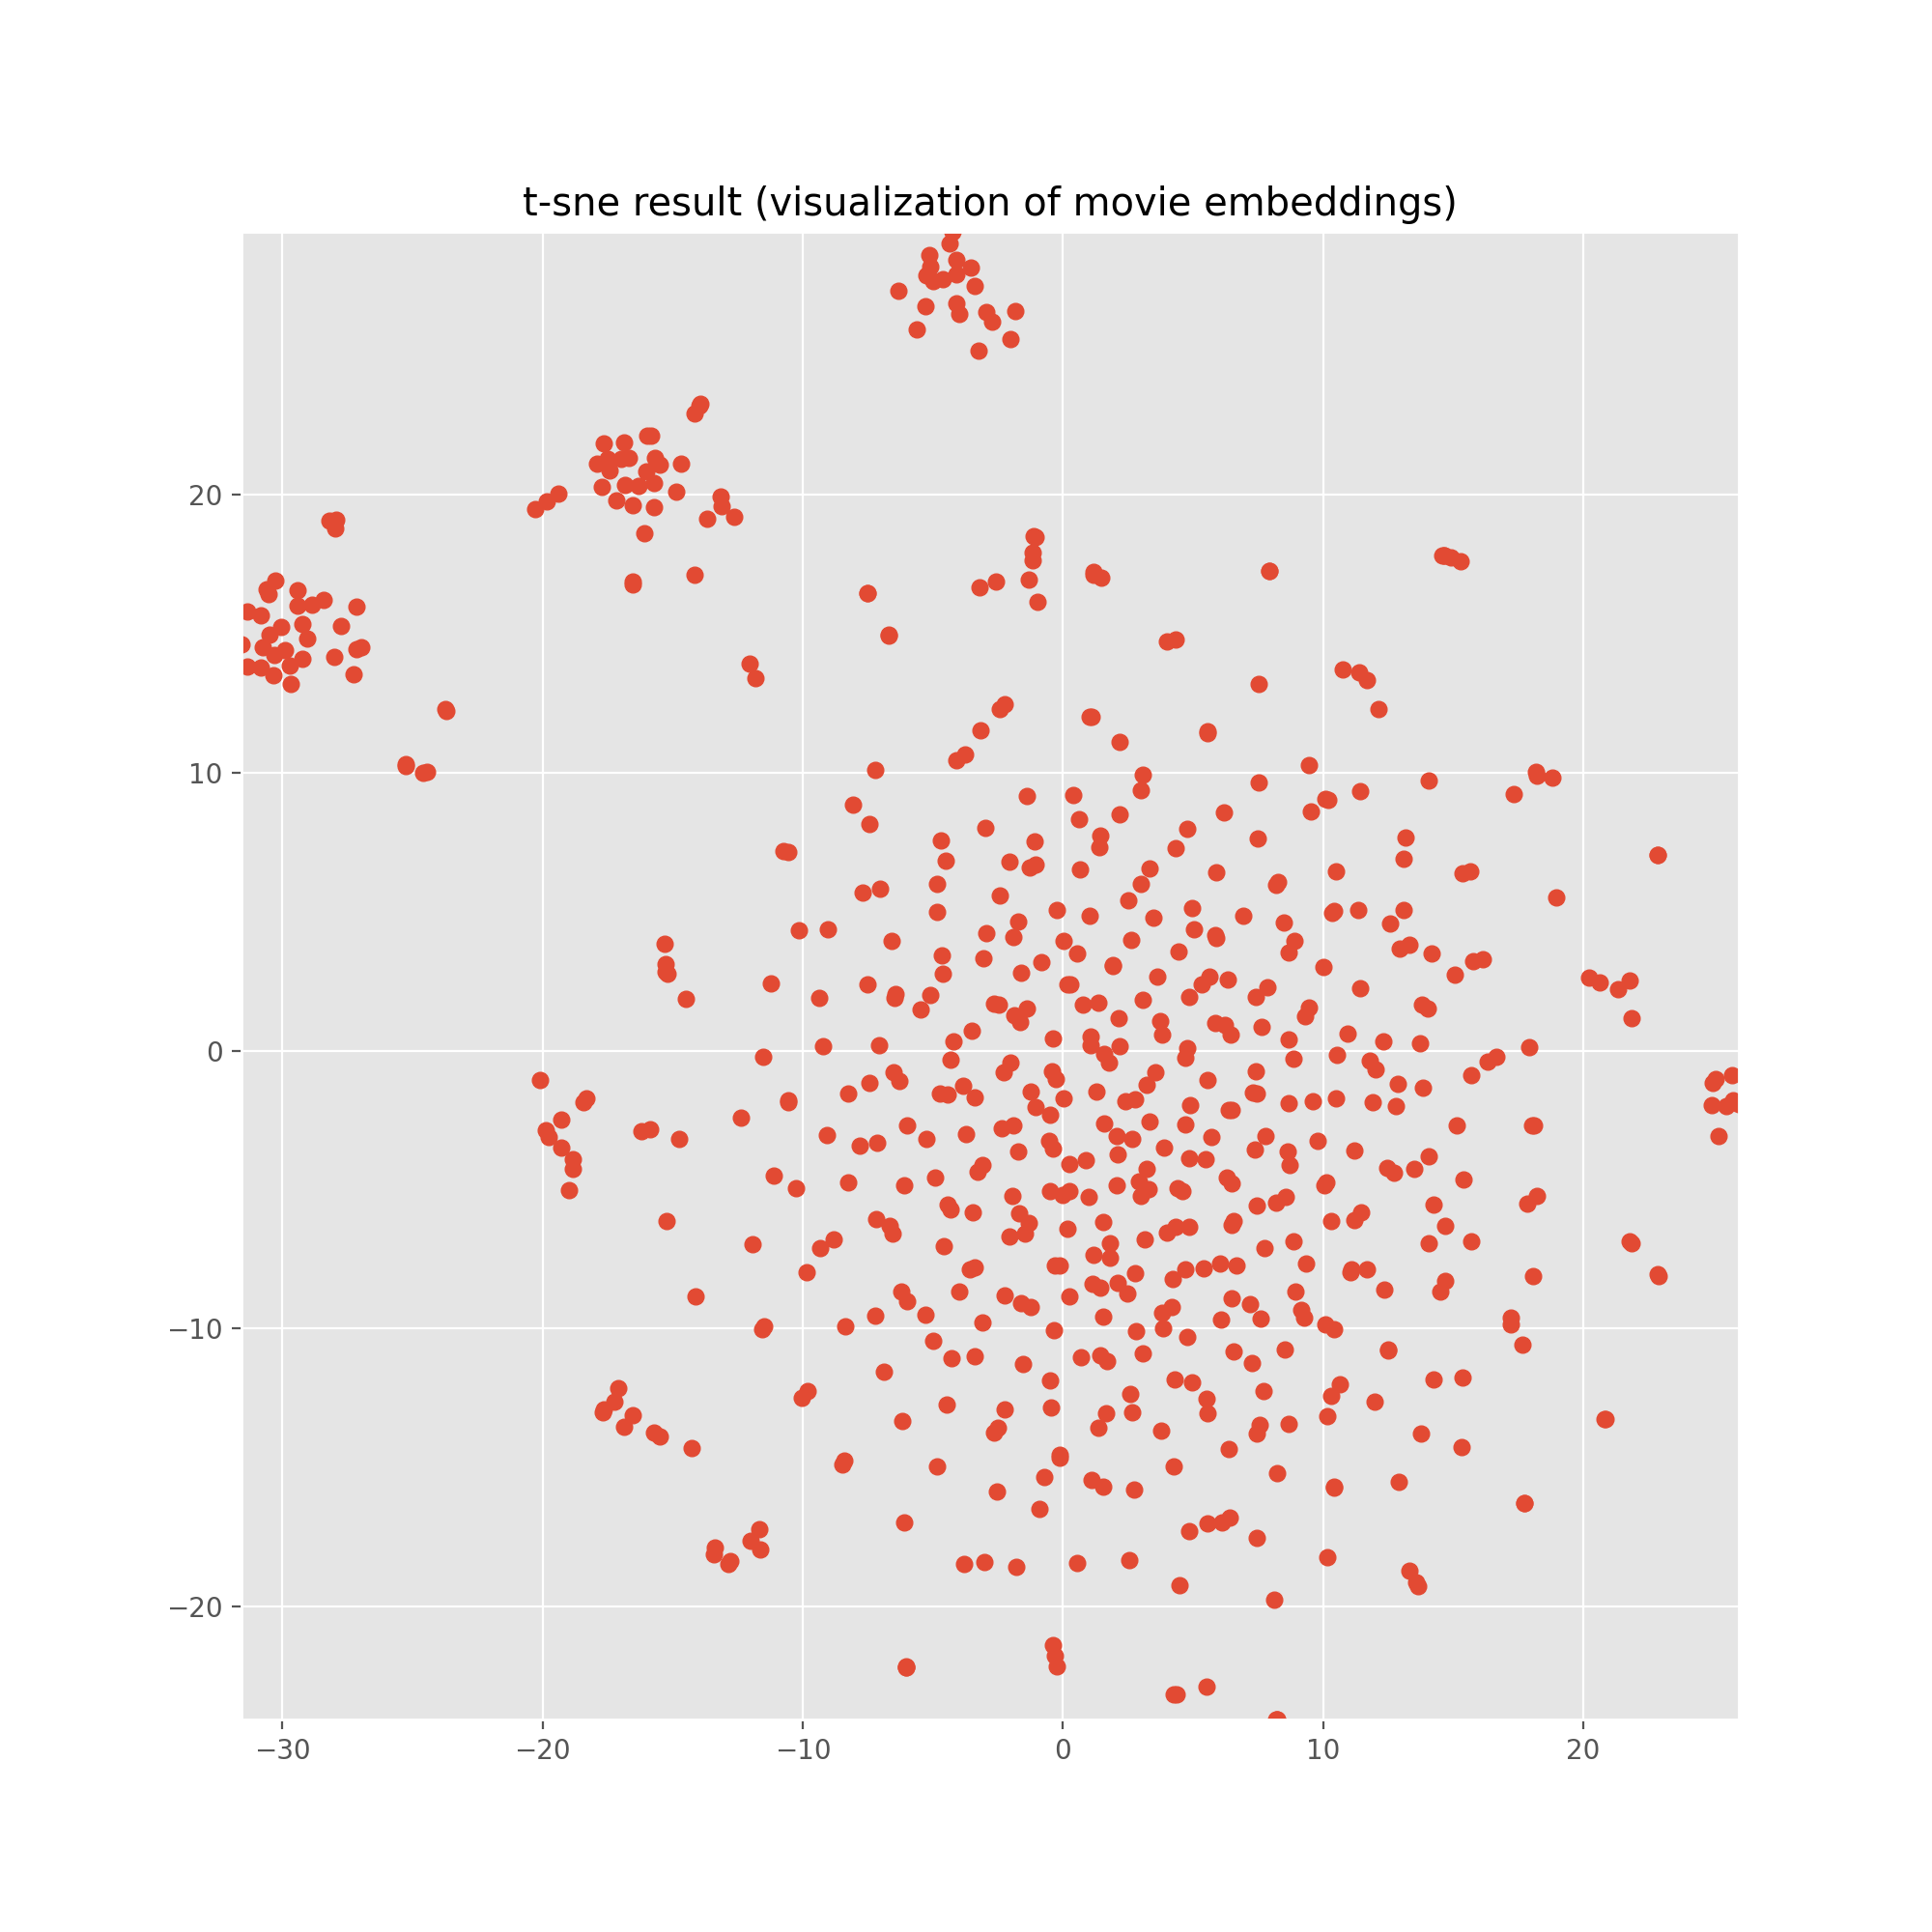

In [51]:
plt.rcParams['figure.figsize'] = [10, 10] # you can change size for your style
plt.xlim(movie_with_embedding['tsne1'].min(), movie_with_embedding['tsne1'].max()) # 축 범위 조정
plt.ylim(movie_with_embedding['tsne2'].min(), movie_with_embedding['tsne2'].max()) # 축 범위 조정

# your code here

# Scatter plot을 그리기
plt.scatter(movie_with_embedding['tsne1'],movie_with_embedding['tsne2'])

# 위의 mplcursors 코드를 이용해 각 point마다 labelling을 할 수 있습니다.
# YOUR_ANNOTATION_LIST는 영화 제목이 되어도 좋고, 영화 장르가 되어도 좋습니다.
# (직관성을 위해 '영화장르'로 labelling 하는 것을 추천합니다.)
mplcursors.cursor(multiple = True).connect(
    "add", lambda sel: sel.annotation.set_text(
          movie_with_embedding.iloc[sel.target.index].name
))
plt.title('t-sne result (visualization of movie embeddings)')
plt.show()

In [159]:
movie_with_embedding.iloc[0].name

'10평파스타&화덕피자'